In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from typing import Any, Dict, Optional, Tuple, Union, List
import os, json, random
from collections import Counter, defaultdict
from pprint import pprint
import numpy as np
from tqdm import tqdm, trange
from transformers import ViTForImageClassification
#os.environ["HF_DATASETS_CACHE"] = "/data/yingshac/hf_cache"
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import pytz
from datetime import datetime
timezone = pytz.timezone('America/New_York') 

In [5]:
from transformers import ViTImageProcessor
model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

from datasets import load_metric
metric = load_metric("accuracy")


/tmp/ipykernel_2811307/3253253806.py:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [13]:
def get_acc(output, gth, verbose=False):
    output, gth = output.detach().cpu(), gth.detach().cpu()
    if verbose:
        print("pred = ", np.argmax(output, axis=1))
        print("gth  = ", gth)
    return metric.compute(predictions=np.argmax(output, axis=1), references=gth)['accuracy'], np.argmax(output, axis=1)

def collate_fn(batch):
    inputs = {}
    inputs['pixel_values'] = processor([x['image'] for x in batch], return_tensors='pt')['pixel_values']
    inputs['label'] = torch.LongTensor([x['label'] for x in batch])
    return inputs

### Finetune ViT

In [4]:
class dataset(Dataset):
    def __init__(self,
                 classes: List[str], # used to define class_ids, order matters
                 imdir: str,
                 data: List,
                 imsize = 64,
                 ):
        super().__init__()
        self.imdir = imdir
        self.data = data ## should be a list of tuples, e.g. (text, image, (mug, cup, left of))
        self.imsize = imsize

        #self.classes = classes
        self.classes = ["empty"]+classes
        self.n2i = {n:i for i, n in enumerate(self.classes)}

    def __len__(self): return len(self.data)*2
    
    def __getitem__(self, i): 
        text, image_path, tuple = self.data[i//2]

        # center crop to a square, then resize
        image = Image.open(os.path.join(self.imdir, image_path))
        width, height = image.size
        new_dimension = min(image.size)
        left = (width - new_dimension)/2
        top = (height - new_dimension)/2
        right = (width + new_dimension)/2
        bottom = (height + new_dimension)/2
        image = image.crop((left, top, right, bottom)).resize((self.imsize, self.imsize))
        
        H, W = self.imsize, self.imsize

        if tuple[-1] in ['left of', 'right of']:
            crop1 = image.crop((0, H//4, W//2, 3*H//4))
            crop2 = image.crop((W//2, H//4, W, 3*H//4))

            crop3 = image.crop((W//4, 0, 3*W//4, H//2))
            crop4 = image.crop((W//4, H//2, 3*W//4, H))
        else:
            crop1 = image.crop((W//4, 0, 3*W//4, H//2))
            crop2 = image.crop((W//4, H//2, 3*W//4, H))

            crop3 = image.crop((0, H//4, W//2, 3*H//4))
            crop4 = image.crop((W//2, H//4, W, 3*H//4))

        f1, f2 = self.n2i[tuple[0]], self.n2i[tuple[1]]
        if tuple[-1] in ['right of', 'in-front of']:
            f1, f2 = f2, f1
        f3, f4 = 0, 0
        image = [crop1, crop2, crop3, crop4][i%4]
        label = [f1, f2, f3, f4][i%4]

        """
        dataset return
        {
            "image": pilimage,
            "labels": int
        }
        """
        # res = {
        #     "sentence": text,
        #     'image': crop2 if i%2 else crop1,
        #     'label': f2 if i%2 else f1,
        # }
        res = {
            "sentence": text,
            'image': image,
            'label': label,
        }
        return res


In [5]:
J = json.load(open("../data/aggregated/whatsup_vlm_b.json", "r"))
annotations = []
for a in J:
    if a[-1][0] in ["sunglasses", "remote", "phone"] or a[-1][1] in ["sunglasses", "remote", "phone"]: continue
    else: annotations.append(a)
occurrences = [a[-1][0] for a in annotations] + [a[-1][1] for a in annotations]
c = Counter(occurrences)

classes = sorted(c.keys(), key=lambda x: (-c[x], x))

print(classes)
D = dataset(
    classes, 
    imdir = "/data/yingshac/clevr_control/data/",
    data = annotations,
    imsize=64
)
train_ratio = 0.9
train_num = int(train_ratio*len(D))
val_num = len(D) - train_num
train_data, val_data = random_split(D, [train_num, val_num])
print(f"{len(train_data)} training examples, {len(val_data)} testing examples")

['book', 'bowl', 'can', 'cap', 'cup', 'mug', 'plate', 'candle', 'flower', 'fork', 'headphones', 'knife', 'scissors', 'spoon', 'tape']
554 training examples, 62 testing examples


In [26]:
def train(net, dataloader, optimizer, criterion, device):
    net.train()
    running_loss, running_acc = [], []
    for batch in tqdm(dataloader):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        bs = len(batch['pixel_values'])
        outputs = net(batch['pixel_values'].to(device))['logits']# (bs, outputs_per_sample*num_classes)

        labels = batch['label'].to(device)

        loss = criterion(outputs, labels)
        acc, _ = get_acc(outputs, labels)

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss.append(loss.item())
        #print(acc)
        running_acc.append(acc)
    return np.mean(running_loss), np.mean(running_acc)

def val(net, dataloader, criterion, device, verbose):
    net.eval()
    epoch_loss, epoch_acc = [], []

    with torch.no_grad():
        for batch in dataloader:
            bs = len(batch['pixel_values'])
            outputs = net(batch['pixel_values'].to(device))['logits'] # (bs, outputs_per_sample*num_classes)

            labels = batch['label'].to(device)

            loss = criterion(outputs, labels)
            acc, _ = get_acc(outputs, labels, verbose=verbose)

            # print statistics
            epoch_loss.append(loss.item())
            epoch_acc.append(acc)
        
    return np.mean(epoch_loss), np.mean(epoch_acc)

In [27]:
labels = D.classes

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)
device = "cuda"
model.to(device)
print()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
print(labels)

['empty', 'book', 'bowl', 'can', 'cap', 'cup', 'mug', 'plate', 'candle', 'flower', 'fork', 'headphones', 'knife', 'scissors', 'spoon', 'tape']


In [28]:
batch_size=16
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=2)
testloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=2)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4) #, momentum=0.9)

In [29]:
print("pilimage image size from dataset.__getitem__(): ", train_data[0]['image'].size)
batch = next(iter(trainloader))
print("image tensor size after processor", batch['pixel_values'].size())

pilimage image size from dataset.__getitem__():  (32, 32)


image tensor size after processor torch.Size([16, 3, 224, 224])


In [30]:
best_val_loss = float('inf')
best_val_acc = 0.0
verbose=False
print("num_classes = ", len(labels))

date = datetime.now(timezone).strftime("%m%d_%H%M%S")
for epc in range(10):

    train_loss, train_acc = train(model, trainloader, optimizer, criterion, device)
    val_loss, val_acc = val(model, testloader, criterion, device, verbose)

    if val_acc >= best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join("/data/yingshac/clevr_control/autoeval", "{}_{}.pt".format(model_name_or_path.split("/")[-1], date)))
    
    print(f'Epoch: {epc+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')
    
print("Training: finish\n")



num_classes =  16


100%|██████████| 35/35 [00:05<00:00,  6.82it/s]


Epoch: 01
	Train Loss: 1.474 | Train Acc: 66.43%
	 Val. Loss: 0.813 |  Val. Acc: 96.65%


100%|██████████| 35/35 [00:05<00:00,  6.85it/s]


Epoch: 02
	Train Loss: 0.480 | Train Acc: 97.50%
	 Val. Loss: 0.311 |  Val. Acc: 98.44%


100%|██████████| 35/35 [00:05<00:00,  6.81it/s]


Epoch: 03
	Train Loss: 0.203 | Train Acc: 99.64%
	 Val. Loss: 0.156 |  Val. Acc: 100.00%


100%|██████████| 35/35 [00:05<00:00,  6.78it/s]


Epoch: 04
	Train Loss: 0.117 | Train Acc: 100.00%
	 Val. Loss: 0.103 |  Val. Acc: 100.00%


100%|██████████| 35/35 [00:05<00:00,  6.74it/s]


Epoch: 05
	Train Loss: 0.078 | Train Acc: 100.00%
	 Val. Loss: 0.074 |  Val. Acc: 100.00%


100%|██████████| 35/35 [00:05<00:00,  6.75it/s]


Epoch: 06
	Train Loss: 0.058 | Train Acc: 100.00%
	 Val. Loss: 0.056 |  Val. Acc: 100.00%


 37%|███▋      | 13/35 [00:02<00:04,  5.29it/s]


KeyboardInterrupt: 

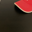

In [145]:
i = random.choice(list(range(len(train_data))))
train_data[i]['image']

In [146]:
print(D.classes[train_data[i]['label']], train_data[i]['label'])
print(train_data[i]['sentence'])

empty 0
A cap to the right of a knife


### Test Finetuned ViT on Generated Samples (singleobj)

In [18]:
#classes = ['empty', 'mug', 'plate', 'book', 'bowl', 'can', 'cap', 'cup', 'remote', 'sunglasses', 
#          'tape', 'candle', 'flower', 'fork', 'headphones', 'scissors', 'spoon', 'knife', 'phone']
classes = ['empty', 'book', 'bowl', 'can', 'cap', 'cup', 'mug', 'plate', 'candle', 'flower', 'fork', 'headphones', 'knife', 'scissors', 'spoon', 'tape']

n2i = {n:i for i, n in enumerate(classes)}
device = "cuda"
ckpt_dir = "/data/yingshac/clevr_control/autoeval/vit-base-patch16-224-in21k_0311_211459.pt"

In [19]:
len(classes)

16

In [29]:
handle = "0514_083120"
whichset="test"
output_folder="output_rbt"
sample_dir = f"../scripts/diffuser_real/{output_folder}/{handle}/infr/{whichset}_sentences"
epc = sorted([f for f in os.listdir(sample_dir)], key=lambda x: int(x[5:].split("_")[0]))[-1]
imsize = 128

pilimages, gth_captions = [], []

for f in os.listdir(f"{sample_dir}/{epc}/samples"):
    if ".txt" in f: continue
    im = Image.open(f"{sample_dir}/{epc}/samples/{f}")
    W, H = im.size
    nrows, ncols = H//imsize, W//imsize
    captions_file = f.replace(".png", ".txt")
    with open(f"{sample_dir}/{epc}/samples/{captions_file}", "r") as captions:
        gth_captions.extend([x.strip() for x in captions.readlines()])
    for r in range(nrows):
        for c in range(ncols):
            left, top = c*imsize, r*imsize
            right, bottom = left+imsize, top+imsize
            pilimage = im.crop((left, top, right, bottom))
            if np.sum(pilimage) == 255*3*imsize*imsize: continue # skip placeholders which are purely white images
            pilimages.append(pilimage)
    print(len(pilimages), len(gth_captions))

18 18
36 36
54 54
72 72
90 90
108 108
126 126
144 144
162 162
180 180
198 198
216 216
234 234
252 252
270 270
288 288
306 306
324 324
342 342
360 360
378 378
396 396
414 414
432 432
450 450
468 468
486 486
504 504
522 522
540 540
558 558
576 576
594 594
612 612
630 630
648 648
666 666
684 684
702 702
720 720
738 738
756 756
774 774
792 792
810 810
828 828
846 846
864 864
882 882
900 900
918 918
936 936
954 954
972 972
990 990
1008 1008
1026 1026
1044 1044
1062 1062
1080 1080
1098 1098
1116 1116
1134 1134
1152 1152
1170 1170
1188 1188
1206 1206
1224 1224
1242 1242
1260 1260
1278 1278
1296 1296
1314 1314
1332 1332
1350 1350
1368 1368
1386 1386
1404 1404
1422 1422
1440 1440
1458 1458
1476 1476
1494 1494
1512 1512
1530 1530
1548 1548
1566 1566
1584 1584
1602 1602
1620 1620
1638 1638
1656 1656
1674 1674
1692 1692
1710 1710
1728 1728
1746 1746
1764 1764
1782 1782
1800 1800


In [21]:
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(classes),
    id2label={str(i): c for i, c in enumerate(classes)},
    label2id={c: str(i) for i, c in enumerate(classes)}
)

state_dict = torch.load(ckpt_dir, map_location=device)
model.load_state_dict(state_dict)
model.to(device)
print()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
ACC = []
gth_labels, vit_pred = [], []
eval_batch_size = 16
outer_batch = []
dataiter = iter(zip(pilimages, gth_captions))

#i = random.choice(list(range(len(pilimages))))
#image, text = pilimages[i], gth_captions[i]
# filename = random.choice(os.listdir("/data/yingshac/clevr_control/data/whatsup_vlms/controlled_clevr/"))[:-5]
# image = Image.open(f"/data/yingshac/clevr_control/data/whatsup_vlms/controlled_clevr/{filename}.jpeg").crop((160, 0, 1120, 960)).resize((64, 64))
# text = " ".join(filename.split("_"))
while True:
    try:
        image, text = next(dataiter)
        if any([k == text.split()[-1] for k in ["sunglasses", "remote", "phone"]]): continue
        outer_batch.append({
            "image": image,
            "label": n2i[text.split()[-1]]
        })
        if len(outer_batch) == eval_batch_size:
            input_batch = collate_fn(outer_batch)
            labels = input_batch['label'].to(device)
            outputs = model(input_batch['pixel_values'].to(device))['logits']

            for b in range(eval_batch_size):
                acc, pred = get_acc(outputs[b:b+1], labels[b:b+1], False)
                ACC.append(acc)
                vit_pred.append(pred.item())
                gth_labels.append(labels[b])
            outer_batch = []
    except StopIteration:
        if len(outer_batch):
            input_batch = collate_fn(outer_batch)
            labels = input_batch['label'].to(device)
            outputs = model(input_batch['pixel_values'].to(device))['logits']
            for b in range(len(outer_batch)):
                acc, pred = get_acc(outputs[b:b+1], labels[b:b+1], False)
                ACC.append(acc)
                vit_pred.append(pred.item())
                gth_labels.append(labels[b])
        break


    

In [42]:
print(len(ACC))
print("acc = ", round(np.mean(ACC), 4))
#print(np.mean([a==1 for a in ACC]))

1500
acc =  0.9827


In [47]:
pilimages[0].size

(128, 128)

In [46]:
for gth_label, acc, pred_lable in zip(gth_labels, ACC, vit_pred):
    if acc == 0:
        print(f"mistake {classes[gth_label]} for {classes[pred_lable]}")

mistake plate for bowl
mistake plate for bowl
mistake headphones for scissors
mistake plate for bowl
mistake headphones for scissors
mistake plate for bowl
mistake plate for bowl
mistake plate for bowl
mistake cup for can
mistake plate for bowl
mistake headphones for scissors
mistake plate for bowl
mistake plate for bowl
mistake plate for bowl
mistake headphones for scissors
mistake plate for bowl
mistake plate for bowl
mistake plate for bowl
mistake plate for bowl
mistake headphones for scissors
mistake plate for bowl
mistake tape for candle
mistake plate for bowl
mistake plate for bowl
mistake plate for bowl
mistake plate for bowl


### Test Finetuned ViT on Generated Samples (two objects)

In [ ]:
classes = ['empty', 'mug', 'plate', 'book', 'bowl', 'can', 'cap', 'cup', 'remote', 'sunglasses', 
          'tape', 'candle', 'flower', 'fork', 'headphones', 'scissors', 'spoon', 'knife', 'phone']
n2i = {n:i for i, n in enumerate(classes)}
device = "cuda"
ckpt_dir = "/data/yingshac/clevr_control/autoeval/vit-base-patch16-224-in21k_0303_182910.pt"

In [62]:
def process_gen_sample(pilimage, gth_caption, whichset):
    W, H = pilimage.size
    crop1 = pilimage.crop((W//4, 0, 3*W//4, H//2)) # behind
    crop2 = pilimage.crop((W//4, H//2, 3*W//4, H)) # front
    crop3 = pilimage.crop((0, H//4, W//2, 3*H//4)) # left
    crop4 = pilimage.crop((W//2, H//4, W, 3*H//4)) # right
    tmp = gth_caption.split()
    if whichset == "train":
        f1, f2 = tmp[1], tmp[-1]
        r = " ".join(tmp[2:-2])
    elif whichset == "test":
        f1, f2 = tmp[0], tmp[-1]
        r = " ".join(tmp[1:-1])
    else: raise ValueError(f"Invalid whichset: {whichset}")
    T = (f1, f2, r)

    if "left of" in r: labels, crops = [n2i[f1], n2i[f2]], [crop3, crop4]
    elif "right of" in r: labels, crops = [n2i[f2], n2i[f1]], [crop3, crop4]
    elif "in-front of" in r: labels, crops = [n2i[f2], n2i[f1]], [crop1, crop2]
    elif "behind" in r: labels, crops = [n2i[f1], n2i[f2]], [crop1, crop2]
    else: raise ValueError(f"Invalid relation: {r}")
    
    return [{
        "image": crop,
        "label": label,
    } for crop, label in zip(crops, labels)], T

In [110]:
handle = "0303_195048"
whichset="train"
sample_dir = f"../scripts/diffuser_real/output/{handle}/infr/{whichset}_sentences"
epc = sorted([f for f in os.listdir(sample_dir)], key=lambda x: int(x[5:].split("_")[0]))[-1]
imsize = 64

pilimages, gth_captions = [], []

for f in os.listdir(f"{sample_dir}/{epc}/samples"):
    if ".txt" in f: continue
    im = Image.open(f"{sample_dir}/{epc}/samples/{f}")
    W, H = im.size
    nrows, ncols = H//imsize, W//imsize
    captions_file = f.replace(".png", ".txt")
    with open(f"{sample_dir}/{epc}/samples/{captions_file}", "r") as captions:
        gth_captions.extend([x.strip() for x in captions.readlines()])
    for r in range(nrows):
        for c in range(ncols):
            left, top = c*imsize, r*imsize
            right, bottom = left+imsize, top+imsize
            pilimage = im.crop((left, top, right, bottom))
            if np.sum(pilimage) == 255*3*64*64: continue # skip placeholders which are purely white images
            pilimages.append(pilimage)
    print(len(pilimages), len(gth_captions))

60 60
108 108
168 168
228 228
288 288
348 348
408 408


In [111]:
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(classes),
    id2label={str(i): c for i, c in enumerate(classes)},
    label2id={c: str(i) for i, c in enumerate(classes)}
)

state_dict = torch.load(ckpt_dir, map_location=device)
model.load_state_dict(state_dict)
model.to(device)
print()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [113]:
ACC = []
vit_pred = []
eval_batch_size = 16
outer_batch = []
dataiter = iter(zip(pilimages, gth_captions))

#i = random.choice(list(range(len(pilimages))))
#image, text = pilimages[i], gth_captions[i]
# filename = random.choice(os.listdir("/data/yingshac/clevr_control/data/whatsup_vlms/controlled_clevr/"))[:-5]
# image = Image.open(f"/data/yingshac/clevr_control/data/whatsup_vlms/controlled_clevr/{filename}.jpeg").crop((160, 0, 1120, 960)).resize((64, 64))
# text = " ".join(filename.split("_"))
while True:
    try:
        image, text = next(dataiter)
        batch, T = process_gen_sample(image, text, whichset)
        outer_batch.extend(batch)
        if len(outer_batch) == 2*eval_batch_size:
            input_batch = collate_fn(outer_batch)
            labels = input_batch['label'].to(device)
            outputs = model(input_batch['pixel_values'].to(device))['logits']

            for b in range(eval_batch_size):
                acc, pred = get_acc(outputs[2*b:2*b+2], labels[2*b:2*b+2], False)
                ACC.append(acc)
                vit_pred.append(pred)
            outer_batch = []
    except StopIteration:
        if len(outer_batch):
            input_batch = collate_fn(outer_batch)
            labels = input_batch['label'].to(device)
            outputs = model(input_batch['pixel_values'].to(device))['logits']
            for b in range(len(outer_batch)//2):
                acc, pred = get_acc(outputs[2*b:2*b+2], labels[2*b:2*b+2], False)
                ACC.append(acc)
                vit_pred.append(pred)
        break


    

In [114]:
print(len(ACC))
print(np.mean(ACC))
print(np.mean([a==1 for a in ACC]))

408
0.4411764705882353
0.3088235294117647


In [115]:
os.listdir(f"{sample_dir}/{epc}/samples")

['0_0_0.txt',
 '0_0_2.png',
 '1_0_1.txt',
 '1_0_2.png',
 '0_0_1.txt',
 '1_0_0.txt',
 '0_0_3.png',
 '0_0_0.png',
 '1_0_1.png',
 '0_0_2.txt',
 '0_0_1.png',
 '1_0_2.txt',
 '0_0_3.txt',
 '1_0_0.png']

In [107]:
for i, a in enumerate(ACC):
    print(i+1, a)

1 1.0
2 1.0
3 1.0
4 0.0
5 1.0
6 0.0
7 0.5
8 1.0
9 1.0
10 0.0
11 0.0
12 0.0
13 0.0
14 1.0
15 0.5
16 1.0
17 0.5
18 1.0
19 0.5
20 0.0
21 0.5
22 0.0
23 1.0
24 0.0
25 0.0
26 0.0
27 1.0
28 1.0
29 1.0
30 0.0
31 0.0
32 0.0
33 0.5
34 1.0
35 1.0
36 0.0
37 1.0
38 1.0
39 0.0
40 0.0
41 0.5
42 1.0
43 0.0
44 0.0
45 0.5
46 0.5
47 1.0
48 1.0
49 1.0
50 0.5
51 1.0
52 0.5
53 1.0
54 1.0
55 1.0
56 1.0
57 0.0
58 0.0
59 0.0
60 1.0
61 0.5
62 0.0
63 0.5
64 1.0
65 0.0
66 0.0
67 0.0
68 1.0
69 0.0
70 0.0
71 1.0
72 0.0
73 0.0
74 0.0
75 1.0
76 1.0
77 0.5
78 0.0
79 0.0
80 0.0
81 0.5
82 0.5
83 0.0
84 0.5
85 0.0
86 0.0
87 0.5
88 1.0
89 1.0
90 1.0
91 0.5
92 0.0
93 0.0
94 1.0
95 0.0
96 1.0
97 1.0
98 1.0
99 1.0
100 0.0
101 1.0
102 1.0
103 0.0
104 0.0
105 1.0
106 1.0
107 0.0
108 0.0
109 0.0
110 1.0
111 0.5
112 1.0
113 0.0
114 0.0
115 0.0
116 0.5
117 0.0
118 1.0
119 1.0
120 0.0
121 1.0
122 1.0
123 0.0
124 1.0
125 0.5
126 0.0
127 0.5
128 0.0
129 0.0
130 0.0
131 0.0
132 1.0
133 0.0
134 0.0
135 0.0
136 0.0
137 0.0
138 0.0
139 

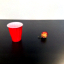

In [133]:
i = random.choice(list(range(len(pilimages))))
#i=9
pilimages[i]

In [134]:
print(gth_captions[i])
print(ACC[i])
f1, f2 = vit_pred[i]
print(classes[f1], classes[f2])

A cup to the left of a flower
1.0
cup flower


### Visualization for examning color distortion

In [20]:
import os, random
from PIL import Image 
from diffusers.utils import make_image_grid

In [21]:
imdir = "/data/yingshac/clevr_control/data/whatsup_vlms/controlled_clevr"
avail_files = [x for x in os.listdir(imdir) if "left" in x or "right" in x]

pilimages = []
for f in random.sample(avail_files, 48):
    im = Image.open(os.path.join(imdir, f))
    W, H = im.size
    square_size = min(H, W)
    left, top, right, bottom = (W-square_size)//2, (H-square_size)//2, (W-square_size)//2+square_size, (H-square_size)//2+square_size
    im = im.crop((left, top, right, bottom)).crop((0, square_size//4, square_size, 3*square_size//4)).resize((64, 32))
    pilimages.append(im)


In [22]:
image_grid = make_image_grid(pilimages, 16, 3)
image_grid.save("tmp/image_grid.png")

In [ ]:
pilimages = []
pilimage = im.crop((left, top, right, bottom))

### Confusion Matrices

In [33]:
import os
import numpy as np
from matplotlib import pyplot as plt

In [48]:
whichset = "test"
folder = f"../scripts/diffuser_real/confusion_matrices/{whichset}"
#classes = ['empty', 'mug', 'plate', 'book', 'bowl', 'can', 'cap', 'cup', 'remote', 'sunglasses', 
#          'tape', 'candle', 'flower', 'fork', 'headphones', 'scissors', 'spoon', 'knife', 'phone']
classes = ['empty', 'book', 'bowl', 'can', 'cap', 'cup', 'mug', 'plate', 'candle', 'flower', 'fork', 
           'headphones', 'knife', 'scissors', 'spoon', 'tape']
CONFUSION = np.zeros((len(classes), len(classes)))
for f in os.listdir(folder):
    m = np.load(open(os.path.join(folder, f), "rb"))
    CONFUSION += m

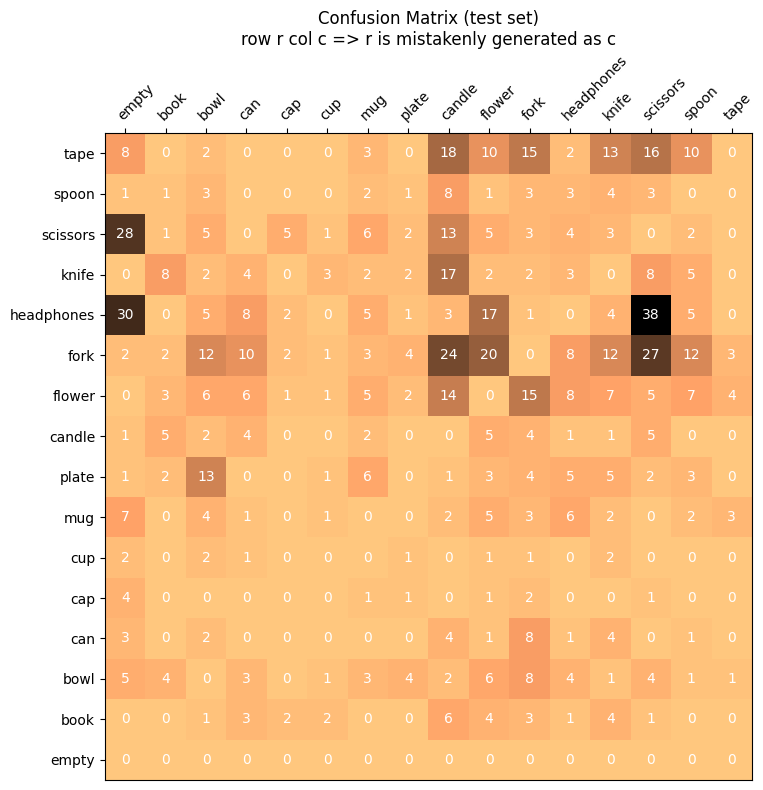

In [49]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(CONFUSION, cmap="copper_r")
ax.invert_yaxis()
ax.xaxis.tick_top()
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(classes)), labels=classes)
ax.set_yticks(np.arange(len(classes)), labels=classes)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="left",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax.text(j, i, int(CONFUSION[i, j]),
                       ha="center", va="center", color="w")

ax.set_title(f"Confusion Matrix ({whichset} set)\nrow r col c => r is mistakenly generated as c")
fig.tight_layout()
plt.show()